In [22]:
# !unzip "/content/Data.zip"

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# I. Data Processing

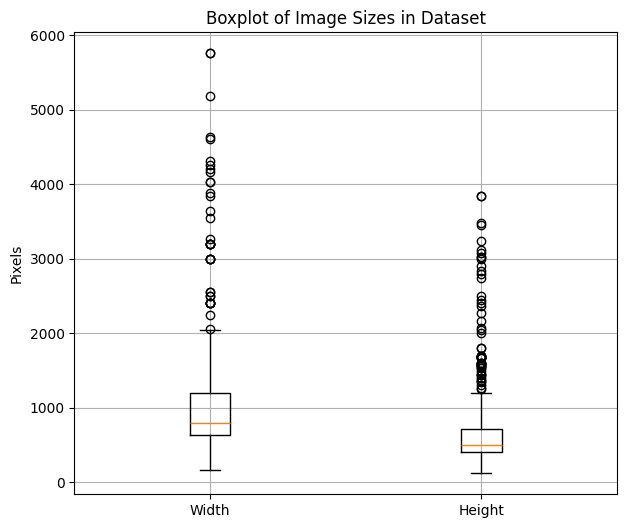

In [49]:
# Boxplot of images' shapes to get an idea
dataset_path = "Data/"

widths = []
heights = []

# Loop through all subdirectories (class folders)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    if os.path.isdir(class_path):  # Ensure it's a folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read image using OpenCV
            image = cv2.imread(image_path)
            if image is not None:
                h, w, _ = image.shape
                widths.append(w)
                heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

plt.figure(figsize=(7, 5))
plt.boxplot([widths, heights], tick_labels=["Width", "Height"])
plt.ylabel("Pixels")
plt.title("Boxplot of Image Sizes in Dataset")
plt.grid(True)
plt.show()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define Image Transformations (Resizing and Normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 128x128
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize pixel values
])

dataset_path = "Data/"

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.6 * len(full_dataset))
val_test_size = len(full_dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size
train_dataset, dev_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using device: cuda


# II. Model definition

In [52]:
class PotholeCNN(nn.Module):
    def __init__(self, dropout_value=0.3):
        super(PotholeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # 64 channels * 32x32 feature map
        self.fc2 = nn.Linear(128, 1)  # Binary classification (pothole or normal)
        self.sigmoid = nn.Sigmoid()  # Activation function for binary classification
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))  # Sigmoid activation for binary output
        return x

# III. Training

In [31]:
def plot_losses(train_losses, dev_losses):
  plt.figure(figsize=(6, 4))
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
  plt.plot(range(1, len(dev_losses) + 1), dev_losses, label='Development Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Development Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [53]:
def training_CNN(num_epochs, model, train_loader, dev_loader, test_loader, device, dropout_value=0.2):

  print("===============================================================================================")
  print(f"\033[1mTraining CNN model with dropout = {dropout_value} \033[0;0m")

  criterion = nn.BCELoss()  # Binary Cross Entropy Loss
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses = []
  dev_losses = []

  for epoch in range(num_epochs):
      total_loss = 0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)  # Reshape labels for BCELoss

          optimizer.zero_grad()  # Reset gradients
          outputs = model(images)  # Forward pass
          loss = criterion(outputs, labels)  # Compute loss
          loss.backward()  # Backpropagation
          optimizer.step()  # Update weights

          total_loss += loss.item()

          predictions = (outputs >= 0.5).float()  # Convert sigmoid outputs to binary (0 or 1)
          correct += (predictions == labels).sum().item()
          total += labels.size(0)

      epoch_loss = total_loss / len(train_loader)
      train_losses.append(epoch_loss)
      epoch_accuracy = correct / total

      # Evaluation on the development set
      model.eval()
      dev_loss = 0
      dev_correct = 0
      dev_total = 0

      with torch.no_grad():
          for images, labels in dev_loader:
              images, labels = images.to(device), labels.float().to(device)
              labels = labels.view(-1, 1)

              outputs = model(images)
              loss = criterion(outputs, labels)
              dev_loss += loss.item()

              predictions = (outputs >= 0.5).float()
              dev_correct += (predictions == labels).sum().item()
              dev_total += labels.size(0)

      dev_epoch_loss = dev_loss / len(dev_loader)
      dev_losses.append(dev_epoch_loss)
      dev_epoch_accuracy = dev_correct / dev_total

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {dev_epoch_loss:.4f}, Val Accuracy: {dev_epoch_accuracy:.4f}")


  plot_losses(train_losses, dev_losses)

  torch.save(model.state_dict(), "pothole_cnn.pth")

  # Testing set
  model.eval()
  test_correct = 0
  test_total = 0

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)

          outputs = model(images)
          predictions = (outputs >= 0.5).float()
          test_correct += (predictions == labels).sum().item()
          test_total += labels.size(0)

  test_accuracy = test_correct / test_total
  print(f"\033[1mTest Accuracy: {test_accuracy:.4f}\033[0;0m")

Training CNN model with dropout = 0.2 
Epoch 1/10, Train Loss: 0.6322, Train Accuracy: 0.6569, Val Loss: 0.3755, Val Accuracy: 0.8676
Epoch 2/10, Train Loss: 0.2929, Train Accuracy: 0.8725, Val Loss: 0.2571, Val Accuracy: 0.8750
Epoch 3/10, Train Loss: 0.1828, Train Accuracy: 0.9289, Val Loss: 0.3228, Val Accuracy: 0.8529
Epoch 4/10, Train Loss: 0.1309, Train Accuracy: 0.9583, Val Loss: 0.1927, Val Accuracy: 0.9118
Epoch 5/10, Train Loss: 0.0796, Train Accuracy: 0.9706, Val Loss: 0.1413, Val Accuracy: 0.9338
Epoch 6/10, Train Loss: 0.0402, Train Accuracy: 0.9926, Val Loss: 0.1882, Val Accuracy: 0.9044
Epoch 7/10, Train Loss: 0.0290, Train Accuracy: 0.9951, Val Loss: 0.1273, Val Accuracy: 0.9191
Epoch 8/10, Train Loss: 0.0294, Train Accuracy: 0.9951, Val Loss: 0.3820, Val Accuracy: 0.8529
Epoch 9/10, Train Loss: 0.0314, Train Accuracy: 0.9951, Val Loss: 0.2362, Val Accuracy: 0.8897
Epoch 10/10, Train Loss: 0.0123, Train Accuracy: 1.0000, Val Loss: 0.2091, Val Accuracy: 0.9044


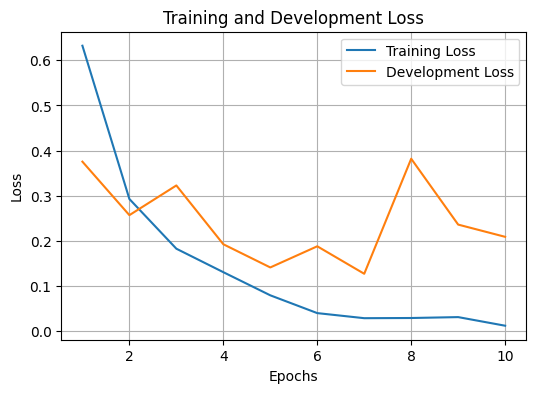

Test Accuracy: 0.9197
Training CNN model with dropout = 0.3 
Epoch 1/10, Train Loss: 0.9503, Train Accuracy: 0.5833, Val Loss: 0.6392, Val Accuracy: 0.6397
Epoch 2/10, Train Loss: 0.5615, Train Accuracy: 0.7304, Val Loss: 0.3676, Val Accuracy: 0.8235
Epoch 3/10, Train Loss: 0.2852, Train Accuracy: 0.8873, Val Loss: 0.3488, Val Accuracy: 0.8162
Epoch 4/10, Train Loss: 0.2009, Train Accuracy: 0.9142, Val Loss: 0.1773, Val Accuracy: 0.8971
Epoch 5/10, Train Loss: 0.1392, Train Accuracy: 0.9436, Val Loss: 0.2274, Val Accuracy: 0.8897
Epoch 6/10, Train Loss: 0.0913, Train Accuracy: 0.9657, Val Loss: 0.2005, Val Accuracy: 0.8971
Epoch 7/10, Train Loss: 0.0942, Train Accuracy: 0.9583, Val Loss: 0.1456, Val Accuracy: 0.9191
Epoch 8/10, Train Loss: 0.0518, Train Accuracy: 0.9877, Val Loss: 0.1896, Val Accuracy: 0.8971
Epoch 9/10, Train Loss: 0.0287, Train Accuracy: 0.9926, Val Loss: 0.1248, Val Accuracy: 0.9338
Epoch 10/10, Train Loss: 0.0141, Train Accuracy: 0.9975, Val Loss: 0.1559, Val Accur

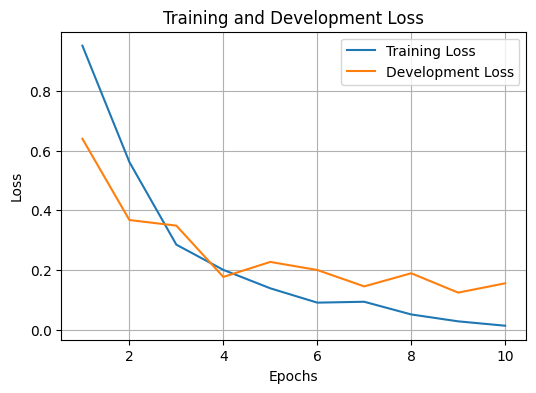

Test Accuracy: 0.8978
Training CNN model with dropout = 0.4 
Epoch 1/10, Train Loss: 1.0149, Train Accuracy: 0.5564, Val Loss: 0.6084, Val Accuracy: 0.7574
Epoch 2/10, Train Loss: 0.5155, Train Accuracy: 0.7819, Val Loss: 0.3151, Val Accuracy: 0.8676
Epoch 3/10, Train Loss: 0.3120, Train Accuracy: 0.8824, Val Loss: 0.3647, Val Accuracy: 0.8382
Epoch 4/10, Train Loss: 0.2031, Train Accuracy: 0.9191, Val Loss: 0.1835, Val Accuracy: 0.9118
Epoch 5/10, Train Loss: 0.1376, Train Accuracy: 0.9510, Val Loss: 0.1691, Val Accuracy: 0.9044
Epoch 6/10, Train Loss: 0.1262, Train Accuracy: 0.9559, Val Loss: 0.1740, Val Accuracy: 0.9044
Epoch 7/10, Train Loss: 0.1265, Train Accuracy: 0.9461, Val Loss: 0.1818, Val Accuracy: 0.8897
Epoch 8/10, Train Loss: 0.0642, Train Accuracy: 0.9902, Val Loss: 0.1532, Val Accuracy: 0.9265
Epoch 9/10, Train Loss: 0.0395, Train Accuracy: 0.9926, Val Loss: 0.1400, Val Accuracy: 0.9412
Epoch 10/10, Train Loss: 0.0288, Train Accuracy: 0.9926, Val Loss: 0.1456, Val Accur

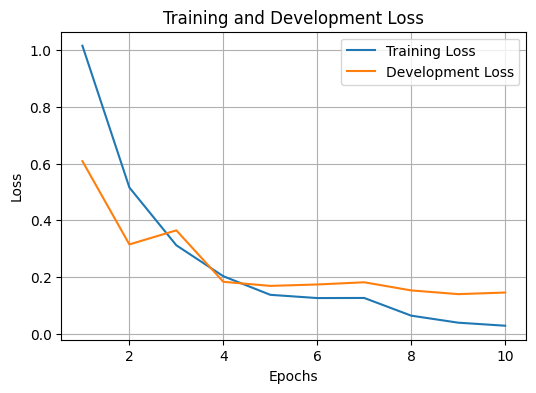

Test Accuracy: 0.8759


In [54]:
num_epochs = 10

for dropout_value in [0.2, 0.3, 0.4]:
  model = PotholeCNN(dropout_value).to(device)
  training_CNN(num_epochs, model, train_loader, val_loader, test_loader, device, dropout_value)